<a href="https://colab.research.google.com/github/alex-smith-uwec/AI_Spring2025/blob/main/FrozenLake_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [75]:

# Initialize FrozenLake environment
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True, render_mode=None)
n_actions = env.action_space.n
n_states = env.observation_space.n


In [76]:
def print_frozen_lake_layout(env):
    desc = env.unwrapped.desc.astype(str)
    size = desc.shape[0]

    for i in range(size):
        row = ""
        for j in range(size):
            cell = f" {desc[i][j]} "
            row += f"|{cell}"
        row += "|"
        print(row)
        print("-" * len(row))
print_frozen_lake_layout(env)

| S | F | F | F |
-----------------
| F | H | F | H |
-----------------
| F | F | F | H |
-----------------
| H | F | F | G |
-----------------


In [93]:
# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration probability
epsilon_min = 0.01
epsilon_decay = 0.999
num_episodes = 5000


In [94]:

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

# Store rewards per episode
rewards_per_episode = []

# Q-learning loop
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state, :])  # Exploit

        next_state, reward, done, truncated, _ = env.step(action)

        # Update Q-value
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]))

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, Avg Reward: {np.mean(rewards_per_episode[-100:]):.2f}")


Episode 500/5000, Epsilon: 0.6064, Avg Reward: 0.01
Episode 1000/5000, Epsilon: 0.3677, Avg Reward: 0.10
Episode 1500/5000, Epsilon: 0.2230, Avg Reward: 0.14
Episode 2000/5000, Epsilon: 0.1352, Avg Reward: 0.35
Episode 2500/5000, Epsilon: 0.0820, Avg Reward: 0.43
Episode 3000/5000, Epsilon: 0.0497, Avg Reward: 0.60
Episode 3500/5000, Epsilon: 0.0301, Avg Reward: 0.67
Episode 4000/5000, Epsilon: 0.0183, Avg Reward: 0.69
Episode 4500/5000, Epsilon: 0.0111, Avg Reward: 0.69
Episode 5000/5000, Epsilon: 0.0100, Avg Reward: 0.67


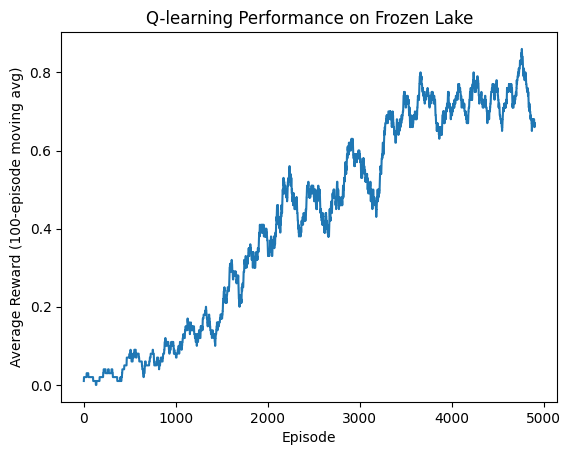

Learned Q-table:
[[0.54361945 0.52257157 0.5222244  0.52311885]
 [0.36843156 0.40530179 0.33542722 0.50471134]
 [0.42576568 0.41497669 0.41512541 0.48427281]
 [0.20837556 0.29015301 0.29004287 0.4720193 ]
 [0.55488561 0.36261907 0.30895336 0.34039   ]
 [0.         0.         0.         0.        ]
 [0.18823504 0.10076368 0.28012775 0.10127279]
 [0.         0.         0.         0.        ]
 [0.41752782 0.33516638 0.35181973 0.60208192]
 [0.51257254 0.66411717 0.50513628 0.36257887]
 [0.63398517 0.45219182 0.33676938 0.16273804]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.60352965 0.45172478 0.77509683 0.33418591]
 [0.74383757 0.85683773 0.74862601 0.74414579]
 [0.         0.         0.         0.        ]]



Optimal state values from Value Iteration:
[0.54201404 0.49878743 0.47067727 0.45683193 0.5584404  0.
 0.35834012 0.         0.59179013 0.64307363 0.61520214 0.
 0.         0.74171617 0.86283528 0.        ]
State | Max Q-Value 

In [95]:
# Plot learning curve
plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Average Reward (100-episode moving avg)")
plt.title("Q-learning Performance on Frozen Lake")
plt.show()

# Display learned Q-table
print("Learned Q-table:")
print(Q)

# Value Iteration to find optimal utilities
V = np.zeros(n_states)
threshold = 1e-6
delta = float("inf")
env_unwrapped = env.unwrapped  # Get the raw environment

while delta > threshold:
    delta = 0
    for state in range(n_states):
        v = V[state]
        V[state] = max(sum(prob * (reward + gamma * V[next_state])
                          for prob, next_state, reward, _ in env_unwrapped.P[state][action])
                       for action in range(n_actions))
        delta = max(delta, abs(v - V[state]))

# Display optimal utility values
print("\n\n\nOptimal state values from Value Iteration:")
print(V)

# Compare max Q-values to optimal state values
print("State | Max Q-Value | Optimal V-Value | Difference")
print("---------------------------------------------------")
for state in range(n_states):
    max_q = np.max(Q[state, :])
    optimal_v = V[state]
    diff = abs(max_q - optimal_v)
    print(f"{state:5} | {max_q:10.4f} | {optimal_v:10.4f} | {diff:10.4f}")


In [98]:
# Extract  policy from Q-table
policy = np.argmax(Q, axis=1)

# Convert to grid shape for FrozenLake (4×4)
policy_grid = policy.reshape(env.unwrapped.desc.shape)

# Map action indices to arrow symbols for readability
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}
policy_symbols = np.vectorize(action_map.get)(policy_grid)

print("Extracted SARSA Policy (←, ↓, →, ↑):")
for row in policy_symbols:
    print(' '.join(row))

print(policy)

Extracted SARSA Policy (←, ↓, →, ↑):
← ↑ ↑ ↑
← ← → ←
↑ ↓ ← ←
← → ↓ ←
[0 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0]



Average reward per episode using the optimal policy: 0.8120
Average number of steps per episode: 92.19


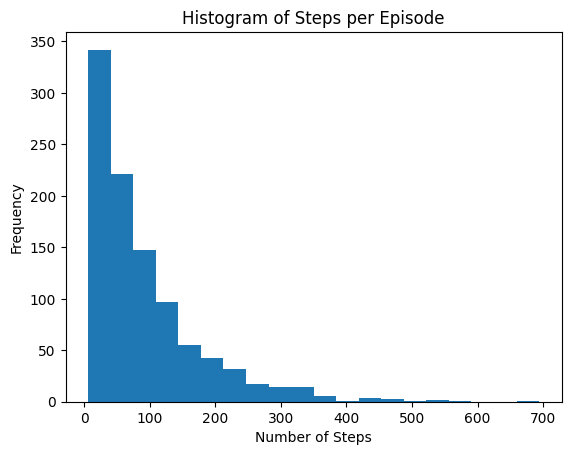

In [82]:
# Simulate average reward per episode using the optimal policy
# In the simulation of average reward, keep track of the number of steps per episode, and make a histogram of the number of steps.

num_simulations = 1000
total_rewards = []
steps_per_episode = []  # Keep track of steps per episode

for _ in range(num_simulations):
    state, _ = env.reset()
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = policy[state]  # Use the extracted policy
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
        steps += 1

    total_rewards.append(total_reward)
    steps_per_episode.append(steps)

average_reward = np.mean(total_rewards)
average_steps = np.mean(steps_per_episode)  # Calculate average steps
print(f"\nAverage reward per episode using the optimal policy: {average_reward:.4f}")
print(f"Average number of steps per episode: {average_steps:.2f}")

# Histogram of number of steps per episode
plt.hist(steps_per_episode, bins=20)
plt.xlabel("Number of Steps")
plt.ylabel("Frequency")
plt.title("Histogram of Steps per Episode")
plt.show()


In [99]:
# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration probability
epsilon_min = 0.01
epsilon_decay = 0.999
num_episodes = 5000

In [100]:
# Initialize Q-table
Q = np.zeros((n_states, n_actions))
rewards_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    # Initial action via epsilon-greedy
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])

    total_reward = 0
    done = False

    while not done:
        next_state, reward, done, truncated, _ = env.step(action)
        # Choose next action via epsilon-greedy
        if np.random.rand() < epsilon:
            next_action = env.action_space.sample()
        else:
            next_action = np.argmax(Q[next_state, :])

        # SARSA update
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (
            reward + gamma * Q[next_state, next_action]
        )

        state, action = next_state, next_action
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, "
              f"Avg Reward: {np.mean(rewards_per_episode[-100:]):.2f}")


Episode 500/5000, Epsilon: 0.6064, Avg Reward: 0.04
Episode 1000/5000, Epsilon: 0.3677, Avg Reward: 0.08
Episode 1500/5000, Epsilon: 0.2230, Avg Reward: 0.15
Episode 2000/5000, Epsilon: 0.1352, Avg Reward: 0.29
Episode 2500/5000, Epsilon: 0.0820, Avg Reward: 0.38
Episode 3000/5000, Epsilon: 0.0497, Avg Reward: 0.51
Episode 3500/5000, Epsilon: 0.0301, Avg Reward: 0.59
Episode 4000/5000, Epsilon: 0.0183, Avg Reward: 0.60
Episode 4500/5000, Epsilon: 0.0111, Avg Reward: 0.69
Episode 5000/5000, Epsilon: 0.0100, Avg Reward: 0.73


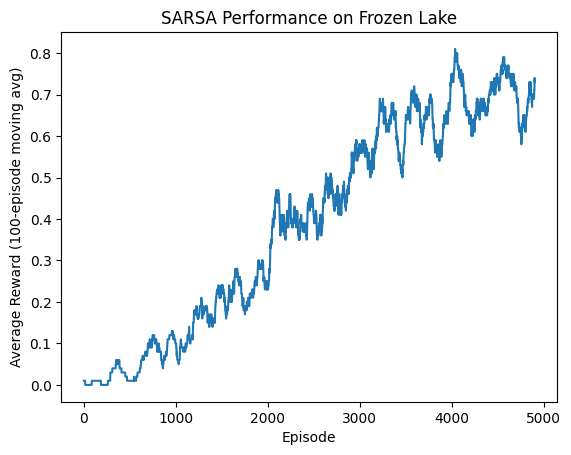

Learned SARSA Q-table:
[[0.49349191 0.43297196 0.43744071 0.43313277]
 [0.10119318 0.16851998 0.08457809 0.39046935]
 [0.32999357 0.17964972 0.17118055 0.1668601 ]
 [0.02197246 0.0481112  0.03391642 0.21131108]
 [0.50927962 0.2831225  0.32303334 0.25010715]
 [0.         0.         0.         0.        ]
 [0.13766427 0.05718335 0.26482822 0.1383322 ]
 [0.         0.         0.         0.        ]
 [0.29340944 0.42225913 0.34025378 0.54193762]
 [0.34376713 0.59739415 0.37671368 0.29980295]
 [0.59233011 0.34759236 0.23103468 0.18115217]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.28268443 0.56867225 0.7409014  0.49271671]
 [0.68115259 0.9137491  0.72984272 0.72810462]
 [0.         0.         0.         0.        ]]


Optimal state values from Value Iteration:
[0.54201404 0.49878743 0.47067727 0.45683193 0.5584404  0.
 0.35834012 0.         0.59179013 0.64307363 0.61520214 0.
 0.         0.74171617 0.86283528 0.        ]
State | Max Q-V

In [101]:
# Plot SARSA learning curve
plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Average Reward (100‑episode moving avg)")
plt.title("SARSA Performance on Frozen Lake")
plt.show()

# Display learned SARSA Q-table
print("Learned SARSA Q-table:")
print(Q)

# Value Iteration to find optimal utilities
V = np.zeros(n_states)
threshold = 1e-6
delta = float("inf")
env_unwrapped = env.unwrapped

while delta > threshold:
    delta = 0
    for state in range(n_states):
        v = V[state]
        V[state] = max(
            sum(prob * (reward + gamma * V[next_state])
                for prob, next_state, reward, _ in env_unwrapped.P[state][action])
            for action in range(n_actions)
        )
        delta = max(delta, abs(v - V[state]))

print("\n\nOptimal state values from Value Iteration:")
print(V)

# Compare SARSA max Q-values to optimal state values
print("State | Max Q-Value | Optimal V-Value | Difference")
print("---------------------------------------------------")
for state in range(n_states):
    max_q = np.max(Q[state, :])
    optimal_v = V[state]
    diff = abs(max_q - optimal_v)
    print(f"{state:5} | {max_q:10.4f} | {optimal_v:10.4f} | {diff:10.4f}")


In [103]:
# Extract SARSA policy from Q-table
policy_sarsa = np.argmax(Q, axis=1)

# Convert to grid shape for FrozenLake (4×4)
policy_grid = policy_sarsa.reshape(env.unwrapped.desc.shape)

# Map action indices to arrow symbols for readability
action_map = {0: '←', 1: '↓', 2: '→', 3: '↑'}
policy_symbols = np.vectorize(action_map.get)(policy_grid)

print("Extracted SARSA Policy (←, ↓, →, ↑):")
for row in policy_symbols:
    print(' '.join(row))

print(policy)
print(policy_sarsa)

Extracted SARSA Policy (←, ↓, →, ↑):
← ↑ ← ↑
← ← → ←
↑ ↓ ← ←
← → ↓ ←
[0 3 3 3 0 0 2 0 3 1 0 0 0 2 1 0]
[0 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0]
